In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')
sys.path.append('../../Mask_RCNN')

In [21]:
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import ImageEnhance, Image

from src.dataset import SartoriusDataset
from src.augmentations import RandomCrop

from src.models import UnetEffNetV2


In [23]:
def make_vis_mask(img, mask=None, invert_img=True, boost_contrast=True):
    _img = np.tile(np.expand_dims(img, axis=-1), 3)

    if invert_img:
        _img = _img.max()-_img
    
    if boost_contrast:
        _img = np.asarray(ImageEnhance.Contrast(Image.fromarray(_img)).enhance(16))

    if mask is None:
        return _img
        
    _mask = np.zeros_like(_img)
    _mask[..., 0] = mask
    
    merged = cv2.addWeighted(_img, 0.75, np.clip(_mask, 0, 1)*255, 0.25, 0.0,)

    return merged

In [24]:
path = Path('/Users/constantine/sartorius-competition/sartorius-cell-instance-segmentation/train')
augmentations = [RandomCrop((512, 704))]

ds = SartoriusDataset(path, augmentations=augmentations)
dataset = ds.dataset
dataset

<BatchDataset shapes: ((None, 512, 704, 1), (None, 512, 704, 1)), types: (tf.float32, tf.int32)>

In [25]:
images, masks = tuple(next(dataset.as_numpy_iterator()))
images.shape, masks.shape

((16, 512, 704, 1), (16, 512, 704, 1))

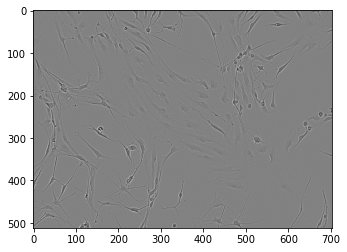

In [26]:
plt.imshow(images[0], cmap='gray')

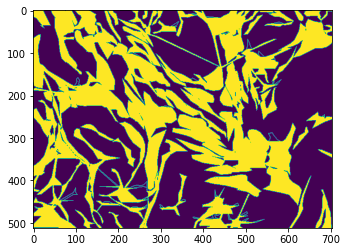

In [27]:
plt.imshow(masks[0])

In [6]:
import cv2
import numpy as np

from mrcnn.utils import Dataset
from pathlib import Path

In [10]:
class SartoriusDetectionDataset(Dataset):
    def load_sartorius_dataset(self, dataset_dir: Path, embeddings=True):
        ext = 'npy' if embeddings else 'png'
        paths = dataset_dir.glob(f'*.{ext}')

        self.embeddings = embeddings

        for idx, path in enumerate(paths):
            mask_path = str(path).replace(f'.{ext}', '_mask.tif')

            self.add_image(
                "sartorius", 
                image_id=idx, 
                path=str(path), 
                mask_path=mask_path
            )

        self.add_class("sartorius", 1, "cell")

    def load_image(self, image_id):
        path = self.image_info[image_id]['path']

        if self.embeddings:
            return np.load(path)

        image = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
        image = image.astype(np.float32) / 255. 

        return image

    def load_mask(self, image_id):
        path = self.image_info[image_id]['mask_path']

        mask_gen = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)

        labels = []
        for label in range(1, mask_gen.max() + 1):
            labels.append(mask_gen == label)
        
        mask = np.stack(labels, axis=-1)

        return mask, np.ones([mask.shape[-1]], dtype=np.int32)


In [11]:
ds_path = Path('/Users/constantine/sartorius-competition/sartorius-cell-instance-segmentation/train')

dataset = SartoriusDetectionDataset()
dataset.load_sartorius_dataset(ds_path, embeddings=False)
dataset.prepare()

In [13]:
image = dataset.load_image(3)
mask, classes = dataset.load_mask(3)

image.shape, mask.shape

((520, 704), (520, 704, 38))

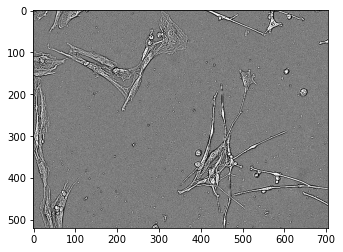

In [26]:
plt.imshow(make_vis_mask((image * 255).astype(np.uint8)), cmap='inferno')

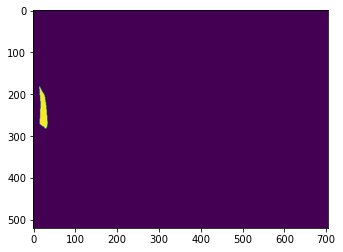

In [17]:
plt.imshow(mask[..., 2])